# Kalman filter with LSTM network driven dynamic

In this demo, we are interested in Bayesian state estimation in Nonlinear State-Space Model. For example, we will use the time series induced by [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system).

In other words, we want to compute the  marginal posterior distribution of the latent (hidden) state $x_k$ at each time step $k$ given the history of the measurements up to the time step k:
$$
p(x_k | y_{1:k}).
$$ 

In [ ]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

In [ ]:
using RxInfer, BenchmarkTools, Flux, ReverseDiff, Random, Plots, LinearAlgebra, ProgressMeter

In [76]:
Random.seed!(1234);

## Generate data

In [77]:
# Lorenz system equations to be used to generate dataset
Base.@kwdef mutable struct Lorenz
    dt::Float64
    σ::Float64
    ρ::Float64
    β::Float64
    x::Float64
    y::Float64
    z::Float64
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end
;

In [78]:
#Dataset
ordered_dataset = []
ordered_parameters = []

for σ = 11:15
    for ρ = 23:27
        for β_nom = 6:9
            attractor = Lorenz(0.02, σ, ρ, β_nom/3.0, 1, 1, 1)
            noise_free_data = [[1.0, 1.0, 1.0]]
            for i=1:99
                step!(attractor)
                push!(noise_free_data, [attractor.x, attractor.y, attractor.z])
            end
            push!(ordered_dataset, noise_free_data)
            push!(ordered_parameters, [σ, ρ, β_nom/3.0])
        end
    end
end

new_order = collect(1:100)
shuffle!(new_order)

dataset = [] #noisy dataset
noise_free_dataset = [] #noise free dataset
lorenz_parameters = []

for i in new_order
    data = []
    push!(noise_free_dataset, ordered_dataset[i])
    push!(lorenz_parameters, ordered_parameters[i])
    for nfd in ordered_dataset[i]
        push!(data,nfd+randn(3))
    end
    push!(dataset, data)
end

trainset = dataset[1:60]
validset = dataset[61:80]
testset = dataset[81:end]

noise_free_trainset = noise_free_dataset[1:60]
noise_free_validset = noise_free_dataset[61:80]
noise_free_testset = noise_free_dataset[81:end]
;

### Data visualization

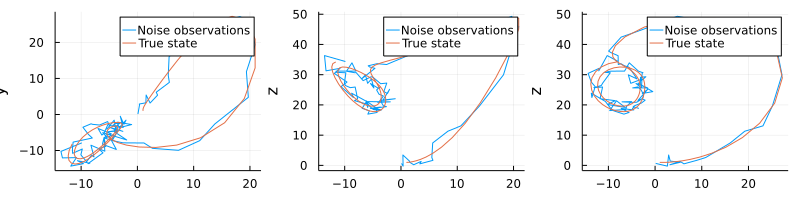

In [79]:
one_nonoise=noise_free_trainset[1]
one=trainset[1]

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = one[i][1], one[i][2], one[i][3]
    gx[i], gy[i], gz[i] = one_nonoise[i][1], one_nonoise[i][2], one_nonoise[i][3]

end
p1=plot(rx,ry,label="Noise observations")
p1=plot!(gx,gy,label="True state")
xlabel!("x")
ylabel!("y")

p2=plot(rx,rz,label="Noise observations")
p2=plot!(gx,gz,label="True state")
xlabel!("x")
ylabel!("z")

p3=plot(ry,rz,label="Noise observations")
p3=plot!(gy,gz,label="True state")
xlabel!("y")
ylabel!("z")

plot(p1, p2, p3, size = (800, 200),layout=(1,3))

### Inference

We use the following state-space model representation:

$$\begin{aligned}
x_k \sim p(x_k | x_{k-1}) \\
y_k \sim p(y_k | x_k).
\end{aligned}$$

where $x_k \sim p(x_k | x_{k-1})$ represents the hidden dynamics of our system. 
The hidden dynamics of the Lorenz system exhibit nonlinearities and hence cannot be solved in the closed form.
One manner of solving this problem is by introducing a neural network to approximate the transition matrix of the Lorenz system. 

$$\begin{aligned}
A_{k-1}=NN(y_{k-1}) \\
p(x_k | x_{k-1})=\mathcal{N}(x_k | A_{k-1}x_{k-1}, Q) \\
p(y_k | x_k)=\mathcal{N}(y_k | Bx_k, R)
\end{aligned}$$

where $NN$ is the neural network. The input is the observation $y_{k-1}$, and output is the trasition matrix $A_{k-1}$.
$B$ denote distortion or measurment matrix. $Q$ and $R$ are covariance matrices. Note that the hidden state $x_k$ comprises three coordinates, i.e. $x_k = (rx_k, ry_k, rz_k)$

In [80]:
# Neural Network model
mutable struct NN
    InputLayer
    OutputLater
    g
    params
    function NN(W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
        InputLayer = Dense(W1, b1, relu)
        Lstm = LSTM(W2_1,W2_2,b2,s2_1)
        OutputLayer = Dense(W3, b3)
        g = Chain(InputLayer, OutputLayer);
        new(InputLayer, OutputLayer, g, (W1,b1,W2_1,W2_2,b2,s2_1,W3,b3))
    end
end

### Model specification
Note that we treat the trasition matrix $A_{k-1}$ as time-varying.

In [81]:
#State Space Model
@model function ssm(n, As, Q::ConstVariable, B::ConstVariable, R::ConstVariable)
   
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior_mean = zeros(3)
    x_prior_cov  = Matrix(Diagonal(ones(3)))
    
    x[1] ~ MvNormalMeanCovariance(x_prior_mean, x_prior_cov)
    y[1] ~ MvNormalMeanCovariance(B * x[1], R) where { q = q(mean)q(out)q(cov) }
    
    for i in 2:n
        x[i] ~ MvNormalMeanCovariance(As[i - 1] * x[i - 1], Q) where { q = q(mean, out)q(cov) }
        y[i] ~ MvNormalMeanCovariance(B * x[i], R) where { q = q(mean)q(out)q(cov) }
    end
    
    return x, y
end

We set distortion matrix $B$ and the covariance matrices $Q$ and $R$ as identity matrix.

In [82]:
Q = Matrix(Diagonal(ones(3)))
B = Matrix(Diagonal(ones(3)))
R = Matrix(Diagonal(ones(3)))
;

We use the *inference* function in the **RxInfer.jl**. Before that, we need to bulid a function to get the matrix $A$ output by the neural network. And the $A$ is treated as a datavar in the inference function.

In [84]:
function get_matrix_AS(data,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
    n = length(data)
    neural = NN(W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
    Flux.reset!(neural)
    As  = map((d) -> Matrix(Diagonal(neural.g(d))), data[1:end-1])
    return As
end

get_matrix_AS (generic function with 1 method)

The weights of neural network $NN$ are initialized as follows:

In [85]:
# Initial model parameters
W1, b1 = randn(5,3)./100, randn(5)./100
W2_1, W2_2, b2, s2_1, s2_2 = randn(5 * 4, 5)./100, randn(5 * 4, 5)./100, randn(5*4)./100, zeros(5), zeros(5)
W3, b3 = randn(3,5)./100, randn(3)./100
;

Before network training, we show the inference results for the hidden states:

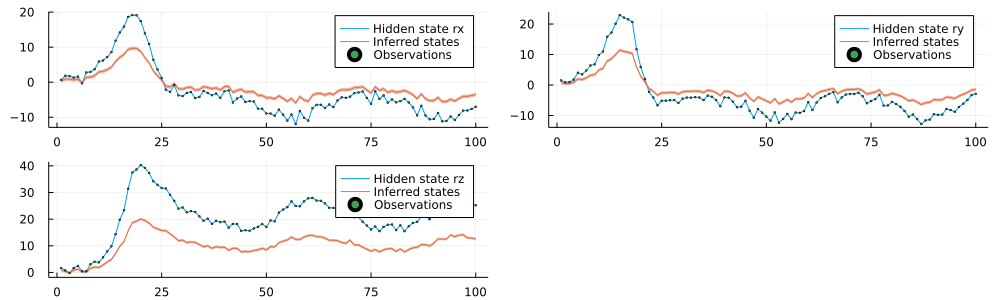

In [86]:
# Performance on an instance from the testset before training
index = 1
data=testset[index]
n=length(data)
result = inference(
    model = ssm(n, get_matrix_AS(data,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3),Q,B,R), 
    data  = (y = data, ), 
    returnvars = (x = KeepLast(), ),
    free_energy = true
)
x_est=result.posteriors[:x]
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx,label="Hidden state rx")
p1 = plot!(rx_est_m,label="Inferred states", ribbon=rx_est_var)
p1 = scatter!(first.(testset[index]), label="Observations", markersize=1.0)

p2 = plot(ry,label="Hidden state ry")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)
p2 = scatter!(getindex.(testset[index], 2), label="Observations", markersize=1.0)

p3 = plot(rz,label="Hidden state rz")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)
p3 = scatter!(last.(testset[index]), label="Observations", markersize=1.0)


plot(p1, p2, p3, size = (1000, 300))

### Training network

In this part, we use the Free Energy as the objective function to optimize the weights of network.

In [87]:
# free energy objective to be optimized during training
function fe_tot_est(W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
    fe_ = 0
    for train_instance in trainset
        result = inference(
            model = ssm(n, get_matrix_AS(train_instance,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3),Q,B,R), 
            data  = (y = train_instance, ), 
            returnvars = (x = KeepLast(), ),
            free_energy = true
        )
        fe_ += result.free_energy[end]
    end
    return fe_
end

fe_tot_est (generic function with 1 method)

In [88]:
# To track the performance on validation set
function fe_valid_est(W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
    fe_ = 0
    for valid_instance in validset
        result = inference(
            model = Model(ssm, n, get_matrix_AS(valid_instance,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3),Q,B,R), 
            data  = (y = valid_instance, ), 
            returnvars = (x = KeepLast(), ),
            free_energy = true
        )
        fe_ += result.free_energy[end]
    end
    return fe_
end

fe_valid_est (generic function with 1 method)

In [89]:
# training
opt = Flux.Optimise.RMSProp(0.02, 0.9)
params = (W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
#if you want get more accurate result, please refine the learning rate and epoch.
@showprogress for epoch in 1:8
    grads = ReverseDiff.gradient(fe_tot_est, params);
    for i=1:length(params)
        Flux.Optimise.update!(opt,params[i],grads[i])
    end
end

Progress:  25%|██████████▎                              |  ETA: 0:00:50

Progress:  38%|███████████████▍                         |  ETA: 0:00:40

Progress:  50%|████████████████████▌                    |  ETA: 0:00:31

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:23

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:16

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:08

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


The following figure shows the state estimation results after training the trained neural network with respect to free energy.

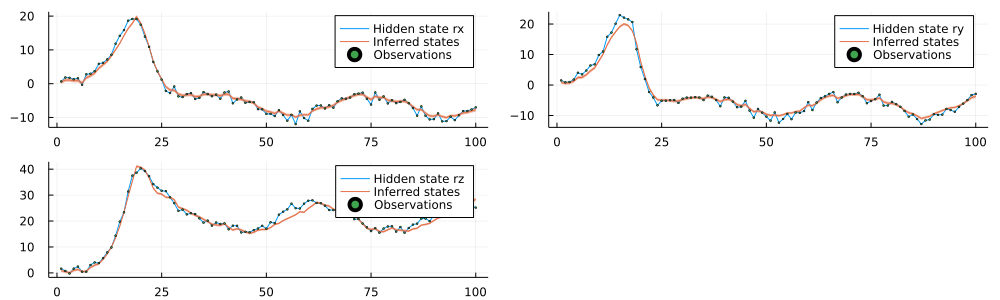

In [91]:
# test after training
index = 1
data = testset[index]
n = length(data)
result = inference(
    model = ssm(n, get_matrix_AS(data,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3),Q,B,R), 
    data  = (y = data, ), 
    returnvars = (x = KeepLast(), ),
    free_energy = true
)
x_est=result.posteriors[:x]

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    gx[i], gy[i], gz[i] = noise_free_testset[index][i][1], noise_free_testset[index][i][2], noise_free_testset[index][i][3]
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx,label="Hidden state rx")
p1 = plot!(rx_est_m,label="Inferred states", ribbon=rx_est_var)
p1 = scatter!(first.(testset[index]), label="Observations", markersize=1.0)

p2 = plot(ry,label="Hidden state ry")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)
p2 = scatter!(getindex.(testset[index], 2), label="Observations", markersize=1.0)

p3 = plot(rz,label="Hidden state rz")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)
p3 = scatter!(last.(testset[index]), label="Observations", markersize=1.0)

plot(p1, p2, p3, size = (1000, 300))